### timeseries of biological and environmental variables from CESM2-4p2z model run

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import pandas as pd
import cftime
import matplotlib.colors as colors
import utils

In [2]:
case = 'b.e21p4.BSSP370.f09_g17.4p2z.002'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/' + case + '/ocn/proc/tseries/month_1/'

In [3]:
path

'/glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/b.e21p4.BSSP370.f09_g17.4p2z.002/ocn/proc/tseries/month_1/'

###  grab desired variables

In [4]:
variables = ['PH','SHF_QSW','TEMP', 'ALK','SALT','NO3','CaCO3_PROD_zint_100m','photoC_TOT_zint_100m',
             'HMXL','coccoC','coccoCaCO3','diatC',
             'spC','cocco_Fe_lim_Cweight_avg_100m','IRON_FLUX']

### define the data range

In [5]:
ds = xr.Dataset()
#ds_fosi_seas = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))  
    
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time", combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    
    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    
    ds = xr.merge([ds,ds_tmp],combine_attrs='override')

starting on  PH
starting on  SHF_QSW
starting on  TEMP
starting on  ALK
starting on  SALT
starting on  NO3
starting on  CaCO3_PROD_zint_100m
starting on  photoC_TOT_zint_100m
starting on  HMXL
starting on  coccoC
starting on  coccoCaCO3
starting on  diatC
starting on  spC
starting on  cocco_Fe_lim_Cweight_avg_100m
starting on  IRON_FLUX


In [7]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='05:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [8]:
cluster, client = get_ClusterClient()
cluster.scale(18) 
client

Client Scheduler: tcp://128.117.208.86:42183 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Integrate phytoplankton vars

In [9]:
attrs = ds['diatC'].attrs
ds['diatC']= (ds['diatC'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds['diatC'].attrs = attrs
ds['diatC'].attrs['units'] = 'mmol/m^2'
        
attrs = ds['coccoC'].attrs
ds['coccoC']= (ds['coccoC'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds['coccoC'].attrs = attrs
ds['coccoC'].attrs['units'] = 'mmol/m^2'

attrs = ds['coccoCaCO3'].attrs
ds['coccoCaCO3']= (ds['coccoCaCO3'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds['coccoCaCO3'].attrs = attrs
ds['coccoCaCO3'].attrs['units'] = 'mmol/m^2'

attrs = ds['spC'].attrs
ds['spC']= (ds['spC'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds['spC'].attrs = attrs
ds['spC'].attrs['units'] = 'mmol/m^2'

### make top 100m of environmental variables

In [10]:
%%time

attrs = ds['TEMP'].attrs
ds['TEMP']= (ds['TEMP'].isel(z_t=slice(0,10))).mean(dim='z_t') # top 100m mean
ds['TEMP'].attrs = attrs
ds['TEMP'].attrs['long_name'] = 'top 100 m mean temperature'

print('temp done')

attrs = ds['ALK'].attrs
ds['ALK']= (ds['ALK'].isel(z_t=slice(0,10))).mean(dim='z_t') # top 100m mean
ds['ALK'].attrs = attrs
ds['ALK'].attrs['long_name'] = 'top 100 m mean total alkalinity'

# print('dic done')

# attrs = ds_fosi['Fe'].attrs
# ds_fosi['Fe']= (ds_fosi['Fe'].isel(z_t=slice(0,10))).mean(dim='z_t') # top 100m mean
# ds_fosi['Fe'].attrs = attrs
# ds_fosi['Fe'].attrs['long_name'] = 'top 100 m mean dissolved inorganic iron'

# print('fe done')

attrs = ds['NO3'].attrs
ds['NO3']= (ds['NO3'].isel(z_t=slice(0,10))).mean(dim='z_t') # top 100m mean
ds['NO3'].attrs = attrs
ds['NO3'].attrs['long_name'] = 'top 100 m mean dissolved inorganic nitrate'


attrs = ds['SALT'].attrs
ds['SALT']= (ds['SALT'].isel(z_t=slice(0,10))).mean(dim='z_t') # top 100m mean
ds['SALT'].attrs = attrs
ds['SALT'].attrs['long_name'] = 'top 100 m mean dissolved inorganic nitrate'

temp done
CPU times: user 19 ms, sys: 0 ns, total: 19 ms
Wall time: 21.5 ms


### get coords and make a ones array for masking

In [11]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
area_m = area * 1.e-4
area_km = area * 1.e-10
lons_norm = utils.normal_lons(lons)

In [12]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [13]:
ds

<xarray.Dataset>
Dimensions:                        (d2: 2, nlat: 384, nlon: 320, time: 1032, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t                            (z_t) float32 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                       (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
    TLONG                          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                           (time) object 2015-02-01 00:00:00 ... 2101...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/17)
    dz                             (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound                     (time, d2) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    PH                             (time, nlat, nlon) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
    SHF_QSW                        (time, nlat, nlon) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
    TEMP                           (time, nlat, nlon) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
    ALK                            (time, nlat, nlon) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
    ...                             ...
    coccoC                         (time, nlat, nlon) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
    coccoCaCO3                     (time, nlat, nlon) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
    diatC                          (time, nlat, nlon) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
    spC                            (time, nlat, nlon) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
    cocco_Fe_lim_Cweight_avg_100m  (time, nlat, nlon) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
    IRON_FLUX                      (time, nlat, nlon) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>

In [14]:
ds['PAlk'] = (ds.ALK + 1.36 * ds.NO3)* (35./ds.SALT)

In [15]:
ds['sAlk'] = (ds.ALK)* (35./ds.SALT)

In [16]:
#ds.time[0:120]
#ds.time[-120:1032]

In [17]:
ds1 = ds.isel(time=slice(0,120)).mean(dim='time')

In [18]:
ds2 = ds.isel(time=slice(-120,1032)).mean(dim='time')

In [19]:
ds_diff = ds2 - ds1

In [20]:
ds_diff = ds_diff.load()

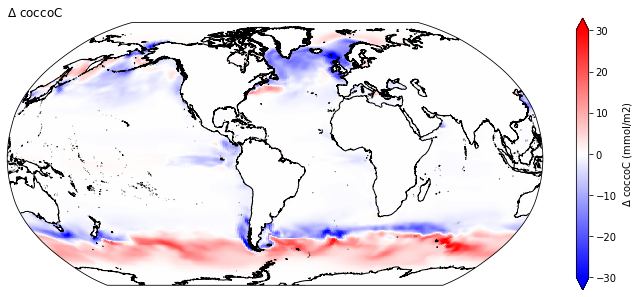

In [17]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('${\Delta}$ coccoC', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_diff.coccoC)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',vmin=-30,vmax=30)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='${\Delta}$ coccoC (mmol/m2)');

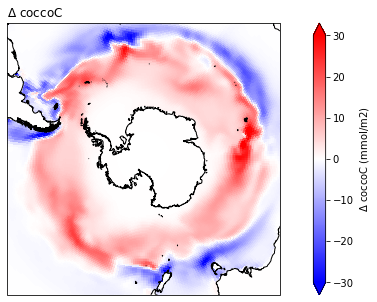

In [22]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax.set_title('${\Delta}$ coccoC', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_diff.coccoC)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',vmin=-30,vmax=30)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='${\Delta}$ coccoC (mmol/m2)');

In [117]:
ds.CaCO3_PROD_zint_100m

<xarray.DataArray 'CaCO3_PROD_zint_100m' (time: 1032, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(1032, 384, 320), dtype=float32, chunksize=(600, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Vertical Integral of CaCO3 Production, 0-100m
    units:         mmol/m^3 cm/s
    grid_loc:      2110
    cell_methods:  time: mean

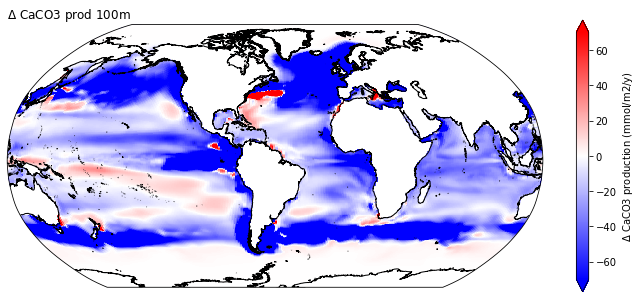

In [126]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('${\Delta}$ CaCO3 prod 100m', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_diff.CaCO3_PROD_zint_100m * 0.01 * 86400.*365)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',vmin=-70,vmax=70)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='${\Delta}$ CaCO3 production (mmol/m2/y)');

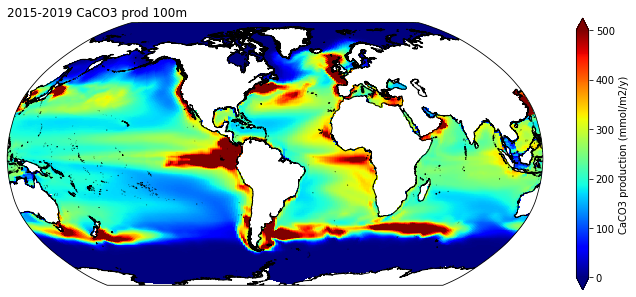

In [128]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('2015-2019 CaCO3 prod 100m', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds1.CaCO3_PROD_zint_100m * 0.01 * 86400.*365)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='jet',vmin=0,vmax=500)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='CaCO3 production (mmol/m2/y)');

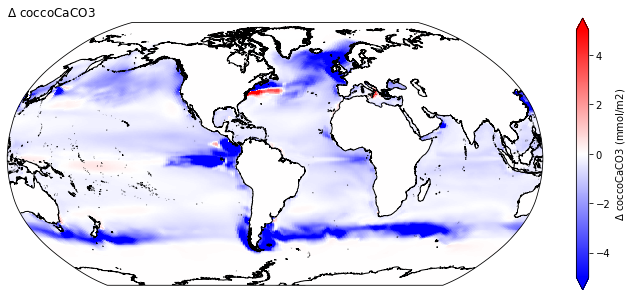

In [123]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('${\Delta}$ coccoCaCO3', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_diff.coccoCaCO3)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',vmin=-5,vmax=5)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='${\Delta}$ coccoCaCO3 (mmol/m2)');

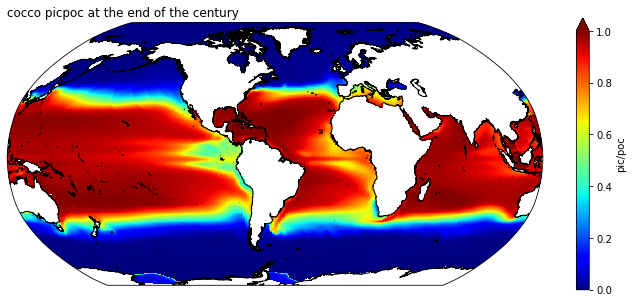

In [24]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('cocco picpoc at the end of the century', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds2.coccoCaCO3/ds2.coccoC)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='jet',vmin=0,vmax=1)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='max', label='pic/poc');

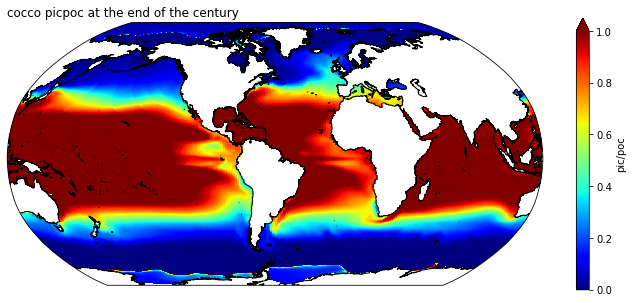

In [133]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('cocco picpoc at the end of the century', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds1.coccoCaCO3/ds1.coccoC)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='jet',vmin=0,vmax=1)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='max', label='pic/poc');

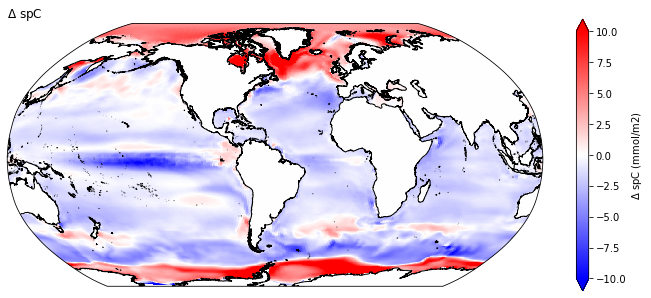

In [25]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('${\Delta}$ spC', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_diff.spC)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',vmin=-10,vmax=10)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='${\Delta}$ spC (mmol/m2)');

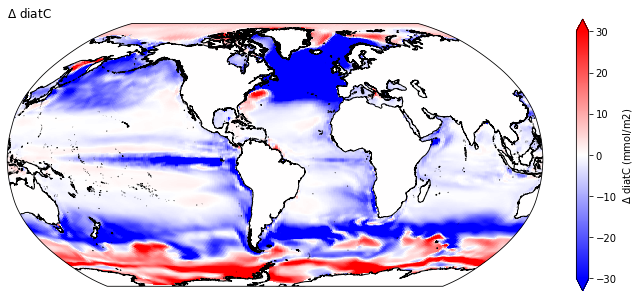

In [26]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('${\Delta}$ diatC', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_diff.diatC)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',vmin=-30,vmax=30)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='${\Delta}$ diatC (mmol/m2)');

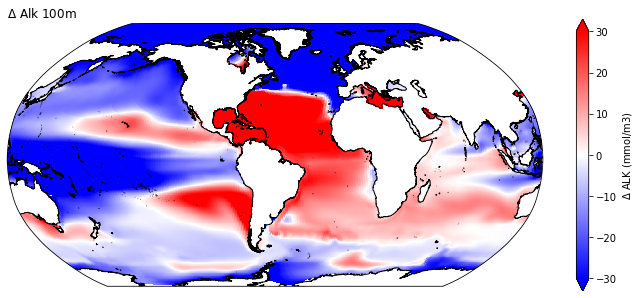

In [77]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('${\Delta}$ Alk 100m', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_diff.ALK)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',vmin=-30,vmax=30)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='${\Delta}$ ALK (mmol/m3)');

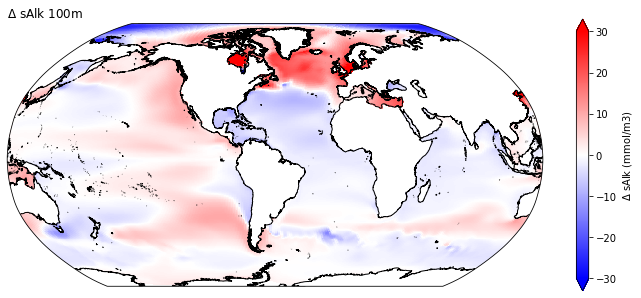

In [100]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('${\Delta}$ sAlk 100m', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_diff.sAlk)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',vmin=-30,vmax=30)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='${\Delta}$ sAlk (mmol/m3)');

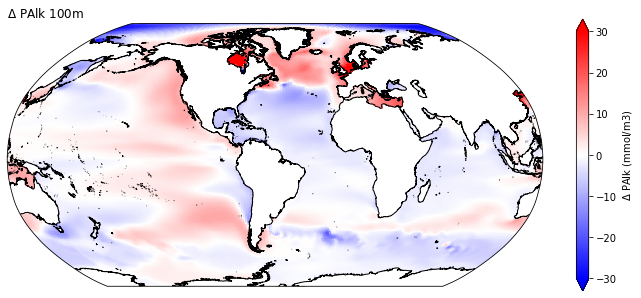

In [94]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
#ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('${\Delta}$ PAlk 100m', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_diff.PAlk)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',vmin=-30,vmax=30)


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='${\Delta}$ PAlk (mmol/m3)');

### Sample the dataset for annual

In [18]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [19]:
%%time
#ds_ann = ds.resample({'time':'A'}, keep_attrs=True).mean(dim='time', keep_attrs=True).compute()

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 14.8 µs


### Seasonal means

In [21]:
ds_djf = xr.Dataset()
ds_jja = xr.Dataset() # for calculating SIZ mask, whether or not the wintertime ifrac makes a big difference for the following growing season
ds_son = xr.Dataset()

sp = 8 # sept index , rearing period (rp)
i = 5 # june index for jja averages
s = 11 #december index for djf averages, summer (s)

for year in np.arange(0,85,1):
        
        print(year,sp,s,i)
    
        
        ### JJA
        jja = ds.isel(time=slice(i,i+3)).mean(dim='time')

        ds_jja = xr.concat([ds_jja,jja],dim='time')

        i = i + 12
        
                
        ### SON
        son = ds.isel(time=slice(sp,sp+3)).mean(dim='time')

        ds_son = xr.concat([ds_son,son],dim='time')

        sp = sp + 12
        
                        
        ### DJF
        djf = ds.isel(time=slice(s,s+3)).mean(dim='time')

        ds_djf = xr.concat([ds_djf,djf],dim='time')

        s = s + 12

0 8 11 5
1 20 23 17
2 32 35 29
3 44 47 41
4 56 59 53
5 68 71 65
6 80 83 77
7 92 95 89
8 104 107 101
9 116 119 113
10 128 131 125
11 140 143 137
12 152 155 149
13 164 167 161
14 176 179 173
15 188 191 185
16 200 203 197
17 212 215 209
18 224 227 221
19 236 239 233
20 248 251 245
21 260 263 257
22 272 275 269
23 284 287 281
24 296 299 293
25 308 311 305
26 320 323 317
27 332 335 329
28 344 347 341
29 356 359 353
30 368 371 365
31 380 383 377
32 392 395 389
33 404 407 401
34 416 419 413
35 428 431 425
36 440 443 437
37 452 455 449
38 464 467 461
39 476 479 473
40 488 491 485
41 500 503 497
42 512 515 509
43 524 527 521
44 536 539 533
45 548 551 545
46 560 563 557
47 572 575 569
48 584 587 581
49 596 599 593
50 608 611 605
51 620 623 617
52 632 635 629
53 644 647 641
54 656 659 653
55 668 671 665
56 680 683 677
57 692 695 689
58 704 707 701
59 716 719 713
60 728 731 725
61 740 743 737
62 752 755 749
63 764 767 761
64 776 779 773
65 788 791 785
66 800 803 797
67 812 815 809
68 824 827 821
6

In [22]:
ds_djf = ds_djf.compute()

### Make a couple climatologies

In [29]:
ds_clim1 = ds.isel(time=slice(0,120)).groupby('time.month').mean('time')
ds_clim2 = ds.isel(time=slice(-120,1032)).groupby('time.month').mean('time')

In [30]:
ds_clim1['perc_cocco']=ds_clim1.coccoC / (ds_clim1.diatC + ds_clim1.coccoC + ds_clim1.spC) * 100.
ds_clim2['perc_cocco']=ds_clim2.coccoC / (ds_clim2.diatC + ds_clim2.coccoC + ds_clim2.spC) * 100.

In [31]:
ds_clim1['perc_diat']=ds_clim1.diatC / (ds_clim1.diatC + ds_clim1.coccoC + ds_clim1.spC) * 100.
ds_clim2['perc_diat']=ds_clim2.diatC / (ds_clim2.diatC + ds_clim2.coccoC + ds_clim2.spC) * 100.

In [32]:
ds_clim1['perc_sp']=ds_clim1.spC / (ds_clim1.diatC + ds_clim1.coccoC + ds_clim1.spC) * 100.
ds_clim2['perc_sp']=ds_clim2.spC / (ds_clim2.diatC + ds_clim2.coccoC + ds_clim2.spC) * 100.

In [33]:
ds_clim1 = ds_clim1.load()
ds_clim2 = ds_clim2.load()

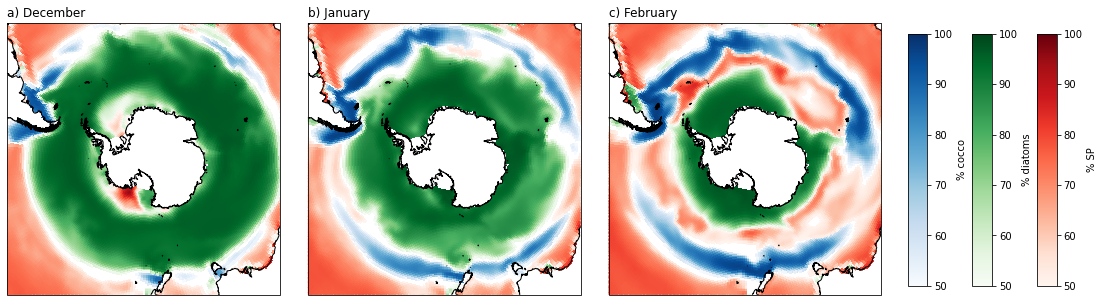

In [36]:
fig = plt.figure(figsize=(18,5))

############### 
ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax.set_title('a) December', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim1.perc_cocco.isel(month=11).where(ds_clim1.perc_cocco.isel(month=11)>50))
pc_c = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Blues',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim1.perc_diat.isel(month=11).where(ds_clim1.perc_diat.isel(month=11)>50))
pc_d = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Greens',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim1.perc_sp.isel(month=11).where(ds_clim1.perc_sp.isel(month=11)>50))
pc_s = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Reds',vmin=50,vmax=100)


ax.coastlines('10m',linewidth=1)


############### 
ax = fig.add_subplot(1,3,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax.set_title('b) January', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim1.perc_cocco.isel(month=0).where(ds_clim1.perc_cocco.isel(month=0)>50))
pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Blues',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim1.perc_diat.isel(month=0).where(ds_clim1.perc_diat.isel(month=0)>50))
pc_d = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Greens',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim1.perc_sp.isel(month=0).where(ds_clim1.perc_sp.isel(month=0)>50))
pc_s = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Reds',vmin=50,vmax=100)


ax.coastlines('10m',linewidth=1)


############### 
ax = fig.add_subplot(1,3,3, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax.set_title('c) February', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim1.perc_cocco.isel(month=1).where(ds_clim1.perc_cocco.isel(month=1)>50))
pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Blues',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim1.perc_diat.isel(month=1).where(ds_clim1.perc_diat.isel(month=1)>50))
pc_d = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Greens',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim1.perc_sp.isel(month=1).where(ds_clim1.perc_sp.isel(month=1)>50))
pc_s = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Reds',vmin=50,vmax=100)

ax.coastlines('10m',linewidth=1)

##########################################################


##########################################################

fig.subplots_adjust(right=0.8, wspace=0.1)

cbar_ax = fig.add_axes([0.82, 0.15, 0.015, 0.7])
cbar1 = fig.colorbar(pc_c, cax=cbar_ax,label='% cocco')

cbar_ax = fig.add_axes([0.87, 0.15, 0.015, 0.7])
cbar1 = fig.colorbar(pc_d, cax=cbar_ax,label='% diatoms')

cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar1 = fig.colorbar(pc_s, cax=cbar_ax,label='% SP')

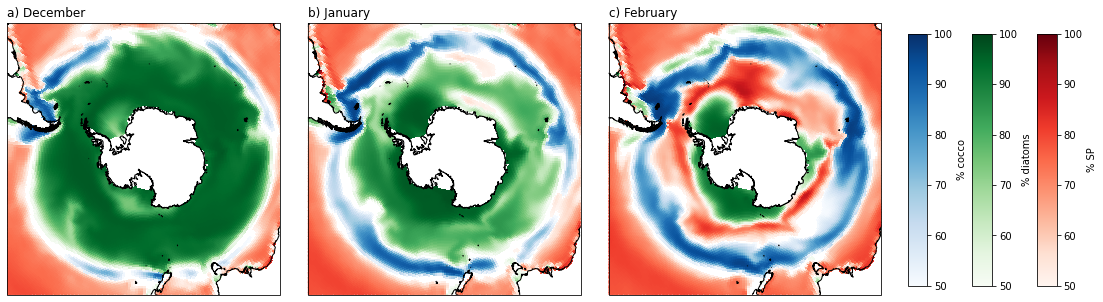

In [37]:
fig = plt.figure(figsize=(18,5))

############### 
ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax.set_title('a) December', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim2.perc_cocco.isel(month=11).where(ds_clim2.perc_cocco.isel(month=11)>50))
pc_c = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Blues',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim2.perc_diat.isel(month=11).where(ds_clim2.perc_diat.isel(month=11)>50))
pc_d = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Greens',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim2.perc_sp.isel(month=11).where(ds_clim2.perc_sp.isel(month=11)>50))
pc_s = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Reds',vmin=50,vmax=100)


ax.coastlines('10m',linewidth=1)


############### 
ax = fig.add_subplot(1,3,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax.set_title('b) January', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim2.perc_cocco.isel(month=0).where(ds_clim2.perc_cocco.isel(month=0)>50))
pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Blues',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim2.perc_diat.isel(month=0).where(ds_clim2.perc_diat.isel(month=0)>50))
pc_d = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Greens',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim2.perc_sp.isel(month=0).where(ds_clim2.perc_sp.isel(month=0)>50))
pc_s = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Reds',vmin=50,vmax=100)


ax.coastlines('10m',linewidth=1)


############### 
ax = fig.add_subplot(1,3,3, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax.set_title('c) February', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim2.perc_cocco.isel(month=1).where(ds_clim2.perc_cocco.isel(month=1)>50))
pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Blues',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim2.perc_diat.isel(month=1).where(ds_clim2.perc_diat.isel(month=1)>50))
pc_d = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Greens',vmin=50,vmax=100)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_clim2.perc_sp.isel(month=1).where(ds_clim2.perc_sp.isel(month=1)>50))
pc_s = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Reds',vmin=50,vmax=100)

ax.coastlines('10m',linewidth=1)

##########################################################


##########################################################

fig.subplots_adjust(right=0.8, wspace=0.1)

cbar_ax = fig.add_axes([0.82, 0.15, 0.015, 0.7])
cbar1 = fig.colorbar(pc_c, cax=cbar_ax,label='% cocco')

cbar_ax = fig.add_axes([0.87, 0.15, 0.015, 0.7])
cbar1 = fig.colorbar(pc_d, cax=cbar_ax,label='% diatoms')

cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar1 = fig.colorbar(pc_s, cax=cbar_ax,label='% SP')

In [35]:
ds_djf['perc_cocco']=ds_djf.coccoC / (ds_djf.diatC + ds_djf.coccoC + ds_djf.spC) * 100.

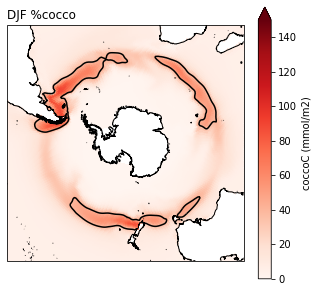

In [36]:
fig = plt.figure(figsize=(18,5))
contour_specs = {'levels': np.arange(-0.6,0.7,0.1)}
siz_lev = [0.5]
############### 
ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('DJF %cocco', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.perc_cocco.mean(dim='time'))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Reds',vmin=0,vmax=150)

cocco_lev = [40]
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.perc_cocco.mean(dim='time'))
cs = ax.contour(lon,lat,field, colors='black',
                levels = cocco_lev,
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='max', label='coccoC (mmol/m2)');

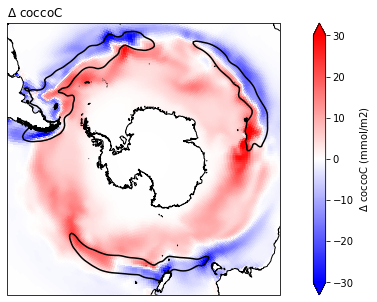

In [38]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax.set_title('${\Delta}$ coccoC', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_diff.coccoC)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',vmin=-30,vmax=30)

cocco_lev = [90]
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.coccoC.mean(dim='time'))
cs = ax.contour(lon,lat,field, colors='black',
                levels = cocco_lev,
                linewidths = 1.5,
                transform=ccrs.PlateCarree())


ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='${\Delta}$ coccoC (mmol/m2)');

### How much does the GCB area change from year to year?

In [31]:
ds_djf['time'] = np.arange(2015,2101,1)

In [32]:
ts_area_GBC = np.full((86),np.nan)
ts_area_GBC_v2 = np.full((86),np.nan)

i=0

for year in np.arange(2015,2101,1):
    
    print(year)
    
    masked_var = ds_djf['perc_cocco'].isel(time=i).where(ds_djf['perc_cocco'].isel(time=i) > 40)
    masked_area = area_km.where(masked_var > 0.)
    
    ts_area_GBC[i] = (masked_area).sum(dim=('nlon','nlat'))
    
    masked_var = ds_djf['coccoC'].isel(time=i).where(ds_djf['coccoC'].isel(time=i) > 90)
    masked_area = area_km.where(masked_var > 0.)
    
    ts_area_GBC_v2[i] = (masked_area).sum(dim=('nlon','nlat'))
    
    
    i = i + 1



2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100


### wikipedia indicates this should be 361 million km^2

In [34]:
area_total_ocean = area_km.where(ds_grid.REGION_MASK > 0.).sum(dim=('nlon','nlat'))

In [35]:
ts_area_GBC/area_total_ocean.values

array([0.02843885, 0.03540326, 0.04084948, 0.03443387, 0.03267619,
       0.03209565, 0.04037715, 0.03307277, 0.04094958, 0.04069134,
       0.03337733, 0.03196644, 0.03594042, 0.02714512, 0.03237576,
       0.02933933, 0.03359645, 0.03260526, 0.0363064 , 0.03537965,
       0.03395994, 0.03162547, 0.0373902 , 0.0309087 , 0.03375467,
       0.03275659, 0.02611651, 0.03368273, 0.03715382, 0.02836143,
       0.03639876, 0.03710555, 0.03701102, 0.03423173, 0.03192256,
       0.03587276, 0.03664906, 0.02867303, 0.03916546, 0.04028405,
       0.03839643, 0.03270902, 0.03907701, 0.03292222, 0.03902779,
       0.02874016, 0.04172035, 0.03360763, 0.03289784, 0.03269107,
       0.03369057, 0.02337736, 0.02562559, 0.03609562, 0.02871361,
       0.03825403, 0.03135455, 0.03459532, 0.03733019, 0.03221861,
       0.03680072, 0.03301763, 0.02828916, 0.03420431, 0.03439641,
       0.03437346, 0.02890816, 0.02935825, 0.02284935, 0.0302235 ,
       0.03222181, 0.03392428, 0.03716088, 0.02986396, 0.03418

## these definitation of GCB, indicate the the GCB covers 2.5 to 3% of ocean 

In [36]:
ts_area_GBC_v2/area_total_ocean.values

array([0.02609508, 0.03293818, 0.03247481, 0.02961262, 0.02780819,
       0.02670928, 0.03851454, 0.02985446, 0.03551147, 0.03009359,
       0.03068677, 0.03079334, 0.03185814, 0.02054355, 0.02749315,
       0.02914919, 0.03377951, 0.02761507, 0.02975001, 0.03027364,
       0.02678268, 0.02508736, 0.02888637, 0.03107164, 0.03105698,
       0.02988661, 0.021589  , 0.02843487, 0.03427789, 0.02977544,
       0.02641915, 0.02948254, 0.03204992, 0.02657304, 0.02924785,
       0.0319067 , 0.02995262, 0.02873002, 0.03071426, 0.03222783,
       0.0280846 , 0.02888334, 0.04107828, 0.03227445, 0.03627918,
       0.03245726, 0.03780111, 0.03132185, 0.02826652, 0.0307307 ,
       0.02605826, 0.02464177, 0.02407247, 0.03316953, 0.02298429,
       0.03400728, 0.03213476, 0.03244846, 0.03266516, 0.03108658,
       0.03241637, 0.03001726, 0.02291434, 0.02924954, 0.02576289,
       0.02609625, 0.02722089, 0.02837964, 0.02298604, 0.03255801,
       0.03330183, 0.03221301, 0.03246447, 0.03123602, 0.03512

In [37]:
ts_area_GBC = xr.DataArray(ts_area_GBC,dims=('time'))
ts_area_GBC_v2 = xr.DataArray(ts_area_GBC_v2,dims=('time'))

In [38]:
ts_area_GBC.std(dim='time')/ts_area_GBC.mean(dim='time')

<xarray.DataArray ()>
array(0.12465933)

In [39]:
ts_area_GBC_v2.std(dim='time')/ts_area_GBC_v2.mean(dim='time')

<xarray.DataArray ()>
array(0.14311115)

In [40]:
ts_area_GBC['time']=np.arange(2015,2101,1)
ts_area_GBC_v2['time']=np.arange(2015,2101,1)

### Line function

In [41]:
def make_line(ts1,ts2):
    ### create model line
    slope, intercept, r_value, p_value, std_err = stats.linregress(ts1,ts2)
    val_min = np.int(np.floor(ts1.min().values))
    val_max = np.int(np.ceil(ts1.max().values))
    i=0
    model_yvar = np.empty([val_max-val_min+1])
    for val in np.arange(val_min,val_max+1,1):
        model_yvar[i] = slope * val + intercept
        i = i + 1
    return(val_min,val_max,model_yvar,slope,intercept,r_value,p_value)

percent-based GCB
------------------
r =  -0.05778151572607998
m =  -0.003531385616489736
p =  0.5971908235807166
biomass-threshold GCB
------------------
r =  0.2113288612201701
m =  0.013371576506115023
p =  0.05079281764892316


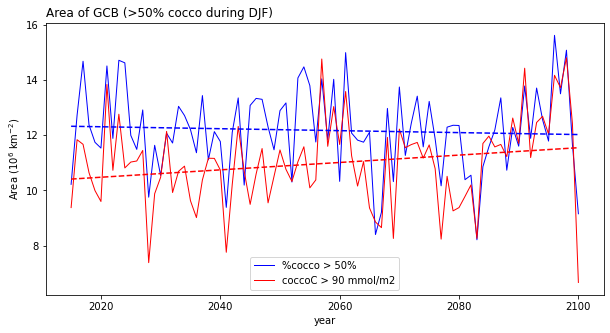

In [42]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Area of GCB (>50% cocco during DJF)',loc='left')

ax.plot(ts_area_GBC.time, ts_area_GBC*1e-6, color='blue', linewidth=1, label='%cocco > 50%')
ax.plot(ts_area_GBC_v2.time, ts_area_GBC_v2*1e-6, color='red', linewidth=1, label='coccoC > 90 mmol/m2')

val_min,val_max,model_npp,slope,b,r,p = make_line(ts_area_GBC.time, ts_area_GBC*1e-6)
ax.plot(np.arange(val_min,val_max+1,1),model_npp,color='blue',linestyle='--') 
print('percent-based GCB')
print('------------------')
print('r = ', r)
print('m = ', slope)
print('p = ', p)

val_min,val_max,model_npp,slope,b,r,p = make_line(ts_area_GBC_v2.time, ts_area_GBC_v2*1e-6)
ax.plot(np.arange(val_min,val_max+1,1),model_npp,color='red',linestyle='--') 
print('biomass-threshold GCB')
print('------------------')
print('r = ', r)
print('m = ', slope)
print('p = ', p)

ax.set(xlabel='year',ylabel='Area (10$^{6}$ km$^{-2}$)');

ax.legend()


### time varying masking, sample conditions in the GCB

In [47]:
ts_GCB = xr.Dataset()



for var in ['TEMP','HMXL','SHF_QSW','diatC','spC','coccoCaCO3','coccoC']: #'picpoc',,'DIC'
    
    print(var)
    i=0
    ts_var = np.full((86),np.nan)
    for year in np.arange(2015,2101,1):

        masked_var = ds_djf[var].isel(time=i).where(ds_djf['perc_cocco'].isel(time=i) > 50)
        masked_area = area_km.where(masked_var > 0.)
        ts_var[i] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
        i = i + 1
        
    ts_GCB[var] = xr.DataArray(ts_var,dims=('time'))

ts_GCB['time']=np.arange(2015,2101,1)

TEMP
HMXL
SHF_QSW
diatC
spC
coccoCaCO3
coccoC


In [ ]:
# fig = plt.figure(figsize=(10,5))

# ax = fig.add_subplot(1,1,1)
# ax.set_title('PIC/POC of coccos in the GCB (>50% cocco during DJF)',loc='left')

# ax.plot(ts_GCB.time, ts_GCB['picpoc'], color='blue', linewidth=1)

# val_min,val_max,model_npp,slope,b,r,p = make_line(ts_GCB.time, ts_GCB['picpoc'])
# ax.plot(np.arange(val_min,val_max+1,1),model_npp,color='black') 

# ax.set(xlabel='year',ylabel='PIC/POC');
# print(r,p)

-0.9603904505623279 2.1959382573932895e-48


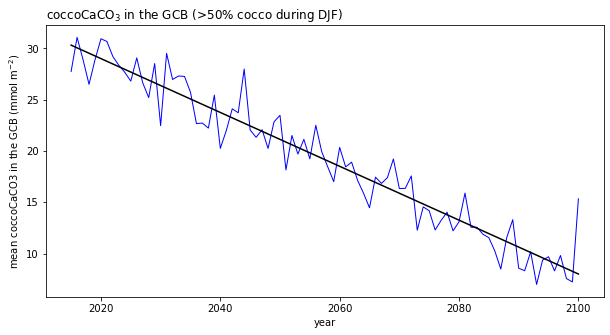

In [49]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('coccoCaCO$_3$ in the GCB (>50% cocco during DJF)',loc='left')

ax.plot(np.arange(2015,2101,1), ts_GCB['coccoCaCO3'], color='blue', linewidth=1)

val_min,val_max,model_npp,slope,b,r,p = make_line(ts_GCB.time, ts_GCB['coccoCaCO3'])
ax.plot(np.arange(val_min,val_max+1,1),model_npp,color='black') 

ax.set(xlabel='year',ylabel='mean coccoCaCO3 in the GCB (mmol m$^{-2}$)');
print(r,p)

In [50]:
# ts_GCB_son = xr.Dataset()



# for var in ['TEMP','Fe','NO3','HMXL','picpoc','SHF_QSW','diatC','spC','DIC']:
    
#     print(var)
#     i=0
#     ts_var = np.full((63),np.nan)
#     for year in np.arange(1958,2021,1):

#         masked_var = ds_son[var].isel(time=i).where(ds_djf['perc_cocco'].isel(time=i) > 50)
#         masked_area = area_km.where(masked_var > 0.)
#         ts_var[i] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
#         i = i + 1
        
#     ts_GCB_son[var] = xr.DataArray(ts_var,dims=('time'))


In [53]:
for var in ['TEMP','HMXL','SHF_QSW','diatC','spC']: #'Fe','NO3''DIC''picpoc'
    
    corr = xr.corr(ts_area_GBC, ts_GCB[var], dim='time')
    print(var, corr.values)
    print()

TEMP 0.016324579667888355

HMXL 0.41483938562677647

SHF_QSW -0.44822668484900274

diatC 0.07560857379575739

spC 0.42537582720935496



In [54]:
# ## now do it with the independent vars being from son (spring time)

# for var in ['TEMP','Fe','NO3','HMXL','picpoc','SHF_QSW','diatC','spC','DIC']:
    
#     corr = xr.corr(ts_area_GBC, ts_GCB_son[var], dim='time')
#     print(var, corr.values)

In [55]:
ds_djf

<xarray.Dataset>
Dimensions:                        (nlat: 384, nlon: 320, time: 86, z_t: 60, z_t_150m: 15)
Coordinates:
    TLONG                          (nlat, nlon) float64 320.6 321.7 ... 319.8
    TLAT                           (nlat, nlon) float64 -79.22 -79.22 ... 72.19
  * z_t                            (z_t) float32 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                       (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * time                           (time) int64 2015 2016 2017 ... 2099 2100
Dimensions without coordinates: nlat, nlon
Data variables: (12/13)
    coccoC                         (time, nlat, nlon) float32 0.0 0.0 ... 0.0
    IRON_FLUX                      (time, nlat, nlon) float32 nan nan ... nan
    coccoCaCO3                     (time, nlat, nlon) float32 0.0 0.0 ... 0.0
    cocco_Fe_lim_Cweight_avg_100m  (time, nlat, nlon) float32 nan nan ... nan
    TEMP                           (time, nlat, nlon) float32 nan nan ... nan
    SHF_QSW                        (time, nlat, nlon) float32 nan nan ... nan
    ...                             ...
    ALK                            (time, nlat, nlon) float32 nan nan ... nan
    dz                             (time, z_t) float32 1e+03 1e+03 ... 2.5e+04
    diatC                          (time, nlat, nlon) float32 0.0 0.0 ... 0.0
    PH                             (time, nlat, nlon) float32 nan nan ... nan
    spC                            (time, nlat, nlon) float32 0.0 0.0 ... 0.0
    perc_cocco                     (time, nlat, nlon) float32 nan nan ... nan

In [131]:
ts_S30S_sum = xr.Dataset()

for var in ['coccoCaCO3','coccoC']:
    
    print(var)
    
    masked_var = ds_djf[var].where(lats<-30) * 0.001 * 1.e-9
    masked_area = area_m.where(masked_var > 0.)
    ts_S30S_sum[var] = (masked_var * masked_area).sum(dim=('nlon','nlat'))


coccoCaCO3
coccoC


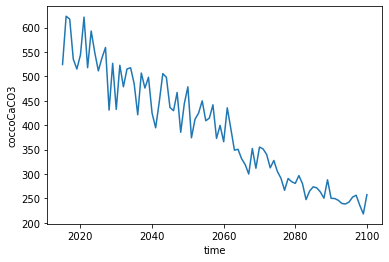

In [58]:
ts_S30S_sum.coccoCaCO3.plot()

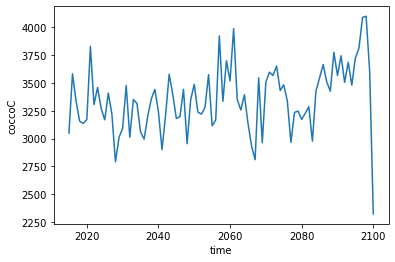

In [132]:
ts_S30S_sum.coccoC.plot()

In [59]:
## look if the sum of coccoCaCO3 has any relation to environmental vars

for var in ['TEMP','HMXL','coccoC']: #,'Fe','NO3''picpoc'
    
    corr = xr.corr(ts_S30S_sum['coccoCaCO3'], ts_GCB[var], dim='time')
    print(var, corr.values)

TEMP -0.27563095490463263
HMXL -0.13330652236736137
coccoC -0.21468037705893295


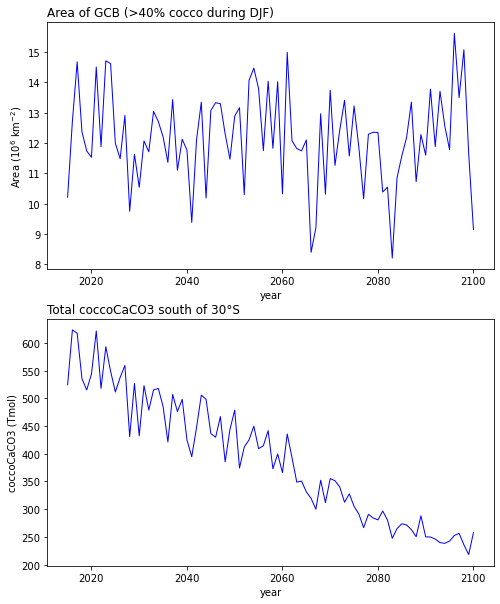

In [60]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(2,1,1)
ax.set_title('Area of GCB (>40% cocco during DJF)',loc='left')

ax.plot(np.arange(2015,2101,1), ts_area_GBC*1e-6, color='blue', linewidth=1)
ax.set(xlabel='year',ylabel='Area (10$^{6}$ km$^{-2}$)');

ax = fig.add_subplot(2,1,2)
ax.set_title('Total coccoCaCO3 south of 30°S',loc='left')

ax.plot(np.arange(2015,2101,1), ts_S30S_sum['coccoCaCO3'], color='blue', linewidth=1)
ax.set(xlabel='year',ylabel='coccoCaCO3 (Tmol)');

r =  0.21899078392087623    p =  0.042787326376547745


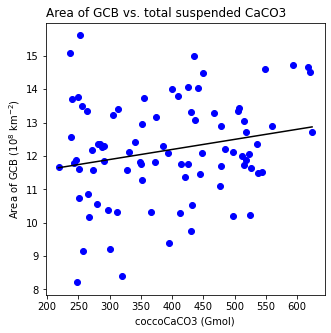

In [61]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Area of GCB vs. total suspended CaCO3',loc='left')

ax.scatter(ts_S30S_sum['coccoCaCO3'], ts_area_GBC*1e-6, color='blue', linewidth=1)

val_min,val_max,model_npp,slope,b,r,p = make_line(ts_S30S_sum['coccoCaCO3'], ts_area_GBC*1e-6)
ax.plot(np.arange(val_min,val_max+1,1),model_npp,color='black') 

ax.set(xlabel='coccoCaCO3 (Gmol)',ylabel='Area of GCB (10$^{8}$ km$^{-2}$)');
print('r = ',r, '   p = ',p)

r =  -0.03198431972105123    p =  0.7700229551997584


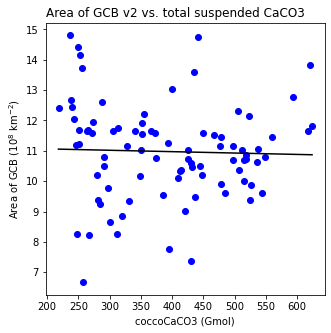

In [62]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Area of GCB v2 vs. total suspended CaCO3',loc='left')

ax.scatter(ts_S30S_sum['coccoCaCO3'], ts_area_GBC_v2*1e-6, color='blue', linewidth=1)

val_min,val_max,model_npp,slope,b,r,p = make_line(ts_S30S_sum['coccoCaCO3'], ts_area_GBC_v2*1e-6)
ax.plot(np.arange(val_min,val_max+1,1),model_npp,color='black') 

ax.set(xlabel='coccoCaCO3 (Gmol)',ylabel='Area of GCB (10$^{8}$ km$^{-2}$)');
print('r = ',r, '   p = ',p)

r =  0.7080945165631526    p =  2.4502102776150873e-14


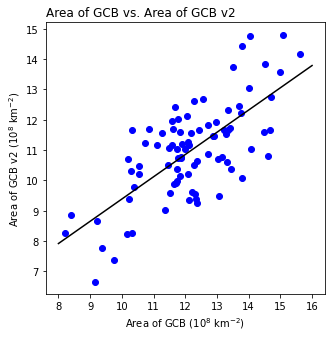

In [63]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Area of GCB vs. Area of GCB v2',loc='left')

ax.scatter(ts_area_GBC*1e-6, ts_area_GBC_v2*1e-6, color='blue', linewidth=1)

val_min,val_max,model_npp,slope,b,r,p = make_line(ts_area_GBC*1e-6, ts_area_GBC_v2*1e-6)
ax.plot(np.arange(val_min,val_max+1,1),model_npp,color='black') 

ax.set(xlabel='Area of GCB (10$^{8}$ km$^{-2}$)',ylabel='Area of GCB v2 (10$^{8}$ km$^{-2}$)');
print('r = ',r, '   p = ',p)

### Let's break up by sector

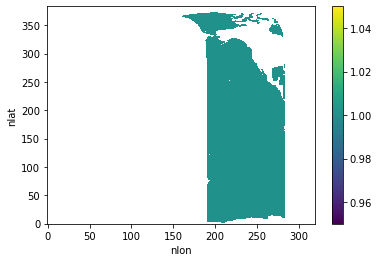

In [64]:
Pac_mask = ones.where(lons > 175).where(lons < 280)
Pac_mask.plot()

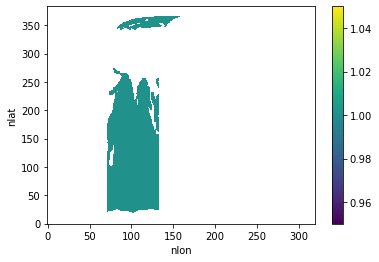

In [65]:
Ind_mask = ones.where(lons > 40).where(lons < 110)
Ind_mask.plot()

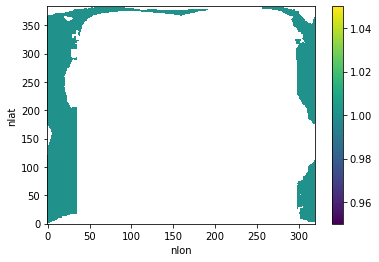

In [66]:
Atl_mask = ones.where(lons_norm > -65).where(lons_norm < 0)
Atl_mask.plot()

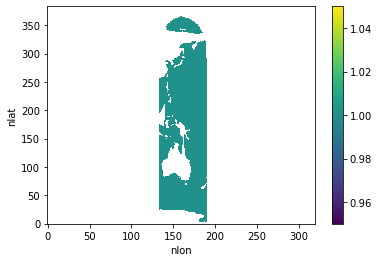

In [67]:
Aust_mask = ones.where(lons > 110).where(lons < 175)
Aust_mask.plot()

In [68]:
masks_regs = {}
masks_regs['Pac'] = Pac_mask
masks_regs['Atl'] = Atl_mask
masks_regs['Aust'] = Aust_mask
masks_regs['Ind'] = Ind_mask

In [70]:
area_GCB_reg = {}

for reg in ['Ind','Atl','Pac','Aust']:

    ts_area = np.full((86),np.nan)

    i=0

    for year in np.arange(2015,2101,1):

        masked_var = ds_djf['perc_cocco'].isel(time=i).where(ds_djf['perc_cocco'].isel(time=i) > 0.5).where(masks_regs[reg]==1)
        masked_area = area_km.where(masked_var > 0.)

        ts_area[i] = (masked_area).sum(dim=('nlon','nlat'))

        i = i + 1
        
    area_GCB_reg[reg] = xr.DataArray(ts_area,dims=('time'))


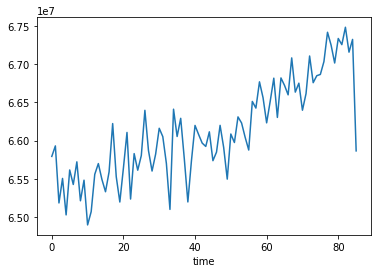

In [71]:
area_GCB_reg['Atl'].plot()

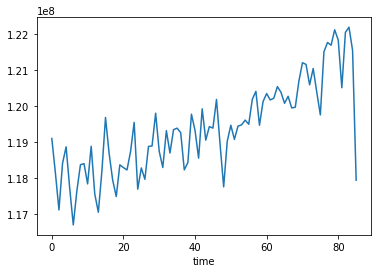

In [72]:
area_GCB_reg['Pac'].plot()

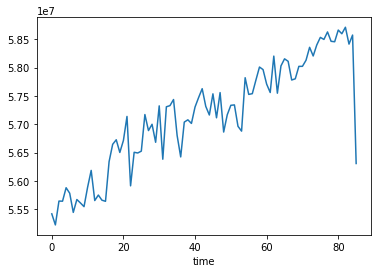

In [73]:
area_GCB_reg['Ind'].plot()

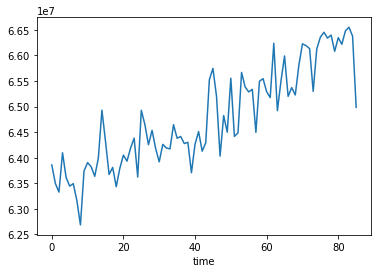

In [74]:
area_GCB_reg['Aust'].plot()

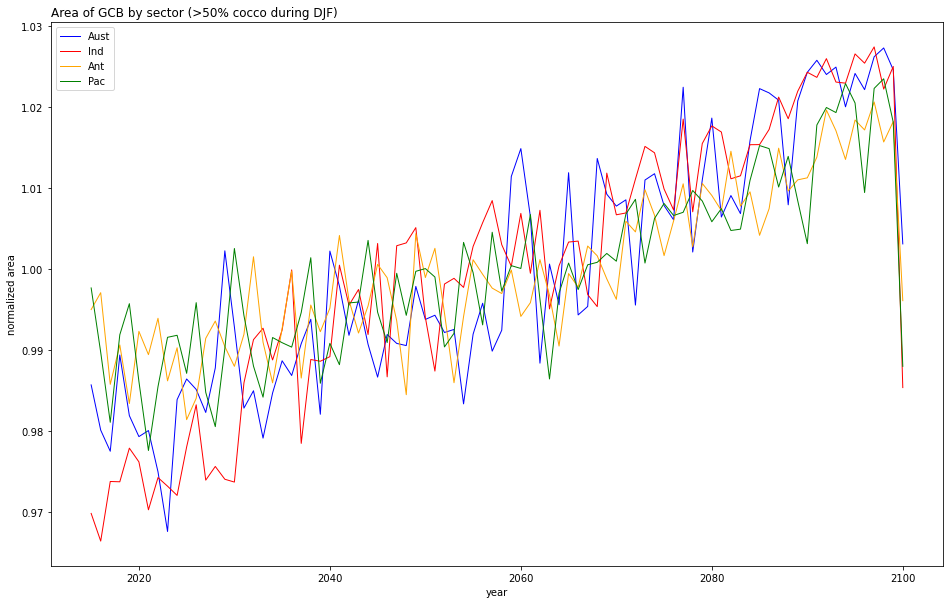

In [75]:
fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(1,1,1)
ax.set_title('Area of GCB by sector (>50% cocco during DJF)',loc='left')

ax.plot(np.arange(2015,2101,1), area_GCB_reg['Aust']/area_GCB_reg['Aust'].mean(dim='time'), color='blue', linewidth=1, label='Aust')
ax.plot(np.arange(2015,2101,1), area_GCB_reg['Ind']/area_GCB_reg['Ind'].mean(dim='time'), color='red', linewidth=1, label='Ind')

ax.plot(np.arange(2015,2101,1), area_GCB_reg['Atl']/area_GCB_reg['Atl'].mean(dim='time'), color='orange', linewidth=1, label='Ant')
ax.plot(np.arange(2015,2101,1), area_GCB_reg['Pac']/area_GCB_reg['Pac'].mean(dim='time'), color='green', linewidth=1, label='Pac')

ax.set(xlabel='year',ylabel='normalized area');

ax.legend()


plot coeff of variation for percent cocco to see if it's the upper boundary or the southern boundary

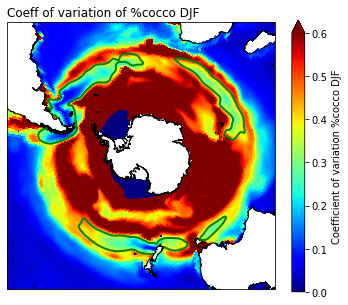

In [76]:
fig = plt.figure(figsize=(6,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('Coeff of variation of %cocco DJF', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.perc_cocco.std(dim='time')/ds_djf.perc_cocco.mean(dim='time'))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='jet',vmin=0,vmax=0.6)

cocco_lev = [40]
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_djf.perc_cocco.mean(dim='time'))
cs = ax.contour(lon,lat,field, colors='green',
                levels = cocco_lev,
                linewidths = 2,
                transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='max', label='Coefficient of variation %cocco DJF');
